# Importações Principais

In [34]:
import pandas as pd 
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from tensorflow.keras.layers import Bidirectional, GlobalMaxPool1D
from tensorflow.keras.models import Model
from tensorflow.keras import initializers, regularizers, constraints, optimizers, layers

# Leitura do dataset

In [60]:
dados_treino = pd.read_csv('data/train.csv')
dados_teste = pd.read_csv('data/test.csv')
dados_label =pd.read_csv("data/test_labels.csv")
dados_treino

id                                       comment_text  \
0       0000997932d777bf  Explanation\nWhy the edits made under my usern...   
1       000103f0d9cfb60f  D'aww! He matches this background colour I'm s...   
2       000113f07ec002fd  Hey man, I'm really not trying to edit war. It...   
3       0001b41b1c6bb37e  "\nMore\nI can't make any real suggestions on ...   
4       0001d958c54c6e35  You, sir, are my hero. Any chance you remember...   
...                  ...                                                ...   
159566  ffe987279560d7ff  ":::::And for the second time of asking, when ...   
159567  ffea4adeee384e90  You should be ashamed of yourself \n\nThat is ...   
159568  ffee36eab5c267c9  Spitzer \n\nUmm, theres no actual article for ...   
159569  fff125370e4aaaf3  And it looks like it was actually you who put ...   
159570  fff46fc426af1f9a  "\nAnd ... I really don't think you understand...   

        toxic  severe_toxic  obscene  threat  insult  identity_hate  
0           0             0        0       0       0              0  
1           0             0        0       0       0              0  
2           0             0        0       0       0              0  
3           0             0        0       0       0              0  
4           0             0        0       0       0              0  
...       ...           ...      ...     ...     ...            ...  
159566      0             0        0       0       0              0  
159567      0             0        0       0       0              0  
159568      0             0        0       0       0              0  
159569      0             0        0       0       0              0  
159570      0             0        0       0       0              0  

[159571 rows x 8 columns]

In [3]:
x_treino = dados_treino['comment_text']
y_treino= dados_treino[['toxic','severe_toxic','obscene','threat','insult','identity_hate' ]]

x_teste =  dados_teste['comment_text']
y_teste= dados_label[['toxic','severe_toxic','obscene','threat','insult','identity_hate' ]]

In [51]:
x_treino

0         explanation why the edits made under my userna...
1         d aww he matches this background colour i am s...
2         hey man i am really not trying to edit war it ...
3         more i can not make any real suggestions on im...
4         you sir are my hero any chance you remember wh...
                                ...                        
159566    and for the second time of asking when your vi...
159567    you should be ashamed of yourself that is a ho...
159568    spitzer umm theres no actual article for prost...
159569    and it looks like it was actually you who put ...
159570    and i really do not think you understand i cam...
Name: comment_text, Length: 159571, dtype: object

In [59]:
y_treino

toxic  severe_toxic  obscene  threat  insult  identity_hate
0           0             0        0       0       0              0
1           0             0        0       0       0              0
2           0             0        0       0       0              0
3           0             0        0       0       0              0
4           0             0        0       0       0              0
...       ...           ...      ...     ...     ...            ...
159566      0             0        0       0       0              0
159567      0             0        0       0       0              0
159568      0             0        0       0       0              0
159569      0             0        0       0       0              0
159570      0             0        0       0       0              0

[159571 rows x 6 columns]

# Pré-processamento

In [4]:
def limpeza(text):
    
    text = text.encode('ascii', errors = 'ignore').decode() #Decodificando caracteres em ASCII
    text = text.lower() #Apenas caracteres minúsculos
    text = re.sub(r'http\S+', ' ', text) #Evitando links
    #Evitando contrações
    text = re.sub(r'#+', ' ', text) #removendo hashtags
    text = re.sub(r'@[A-Za-z0-9]+', ' ', text) #removendo menções
    text = re.sub(r"([A-Za-z]+)'s", r"\1 is", text) #substituindo 's por i
    text = re.sub(r"what's", "what is ", text) 
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"won't", "will not ", text) 
    text = re.sub(r"\'ve", " have ", text) 
    text = re.sub(r"can't", "can not ", text) 
    text = re.sub(r"n't", " not ", text) 
    text = re.sub(r"isn't", "is not ", text) 
    text = re.sub(r"i'm", "i am ", text) 
    text = re.sub(r"\'re", " are ", text) 
    text = re.sub(r"\'d", " would ", text) 
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub('\W', ' ', text) #remove qualquer caracter não alfanumérico
    text = re.sub('\s+', ' ', text) # remove espaçamentos do tipo \r\n\t\f\v 
    text = re.sub(r'\d+', ' ', text) #remove digitos
    text = text.strip(' ') #Removendo espaços do começo e fim 
    return text


# WordCloud para vizualização das palavras mais frequentes em cada tipo de comentário após o pré-processamento

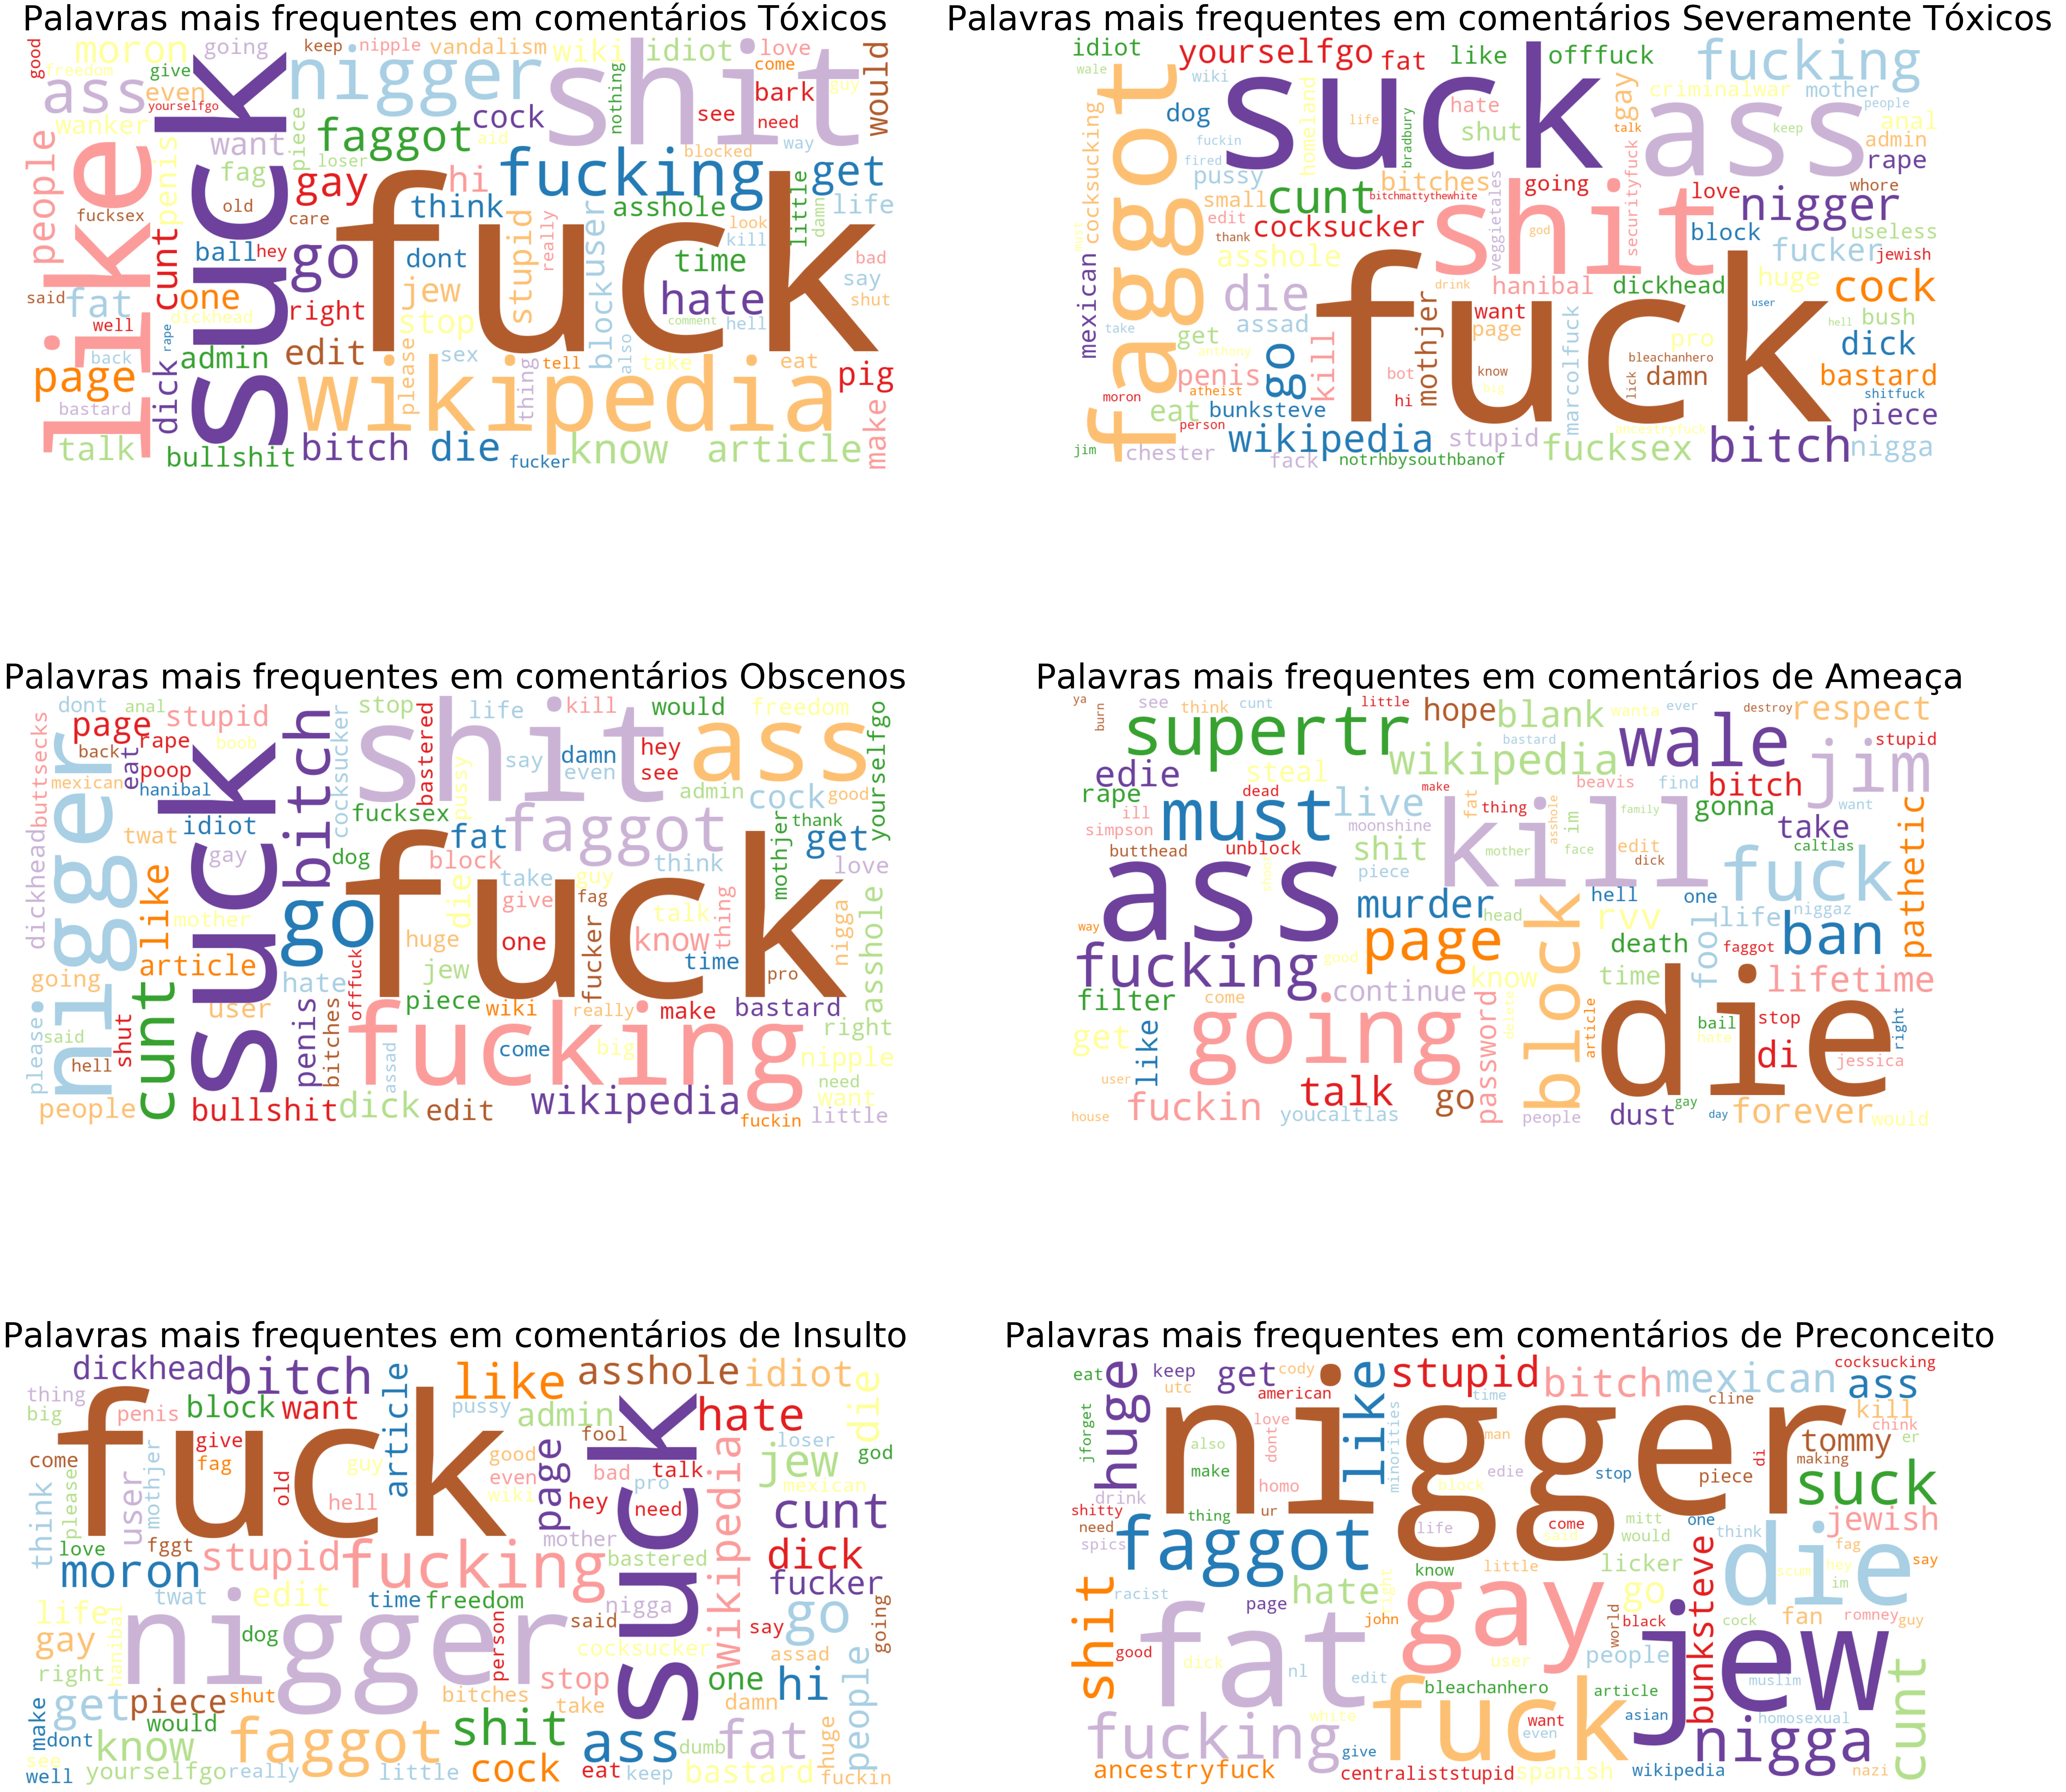

In [47]:

#wordcloud para comentários tóxicos

subset=dados_treino[dados_treino.toxic==True]
text=subset.comment_text.values
wc= WordCloud(background_color="white",max_words=100, stopwords=stop,collocations=False,width=1600, height=800)
wc.generate(" ".join(text))
plt.figure(figsize = (100,100))
plt.subplot(321)
plt.axis("off")
plt.title("Palavras mais frequentes em comentários Tóxicos ", fontsize=100)
plt.imshow(wc.recolor(colormap= 'Paired' , random_state=244), alpha=0.98, interpolation="bilinear")

#wordcloud para comentários severamente tóxicos
plt.subplot(322)
subset=dados_treino[dados_treino.severe_toxic==True]
text=subset.comment_text.values
wc= WordCloud(background_color="white",max_words=100, stopwords=stop,collocations=False,width=1600, height=800)
wc.generate(" ".join(text))
plt.axis("off")
plt.title("Palavras mais frequentes em comentários Severamente Tóxicos ", fontsize=100)
plt.imshow(wc.recolor(colormap= 'Paired' , random_state=244), alpha=0.98, interpolation="bilinear")

#wordcloud para comentários obscenos
plt.subplot(323)
subset=dados_treino[dados_treino.obscene==True]
text=subset.comment_text.values
wc= WordCloud(background_color="white",max_words=100, stopwords=stop,collocations=False,width=1600, height=800)
wc.generate(" ".join(text))
plt.axis("off")
plt.title("Palavras mais frequentes em comentários Obscenos ", fontsize=100)
plt.imshow(wc.recolor(colormap= 'Paired' , random_state=244), alpha=0.98, interpolation="bilinear")

#wordcloud para comentários de ameaça
plt.subplot(324)
subset=dados_treino[dados_treino.threat==True]
text=subset.comment_text.values
wc= WordCloud(background_color="white",max_words=100, stopwords=stop,collocations=False,width=1600, height=800)
wc.generate(" ".join(text))
plt.axis("off")
plt.title("Palavras mais frequentes em comentários de Ameaça ", fontsize=100)
plt.imshow(wc.recolor(colormap= 'Paired' , random_state=244), alpha=0.98, interpolation="bilinear")


#wordcloud para comentários de insulto
plt.subplot(325)
subset=dados_treino[dados_treino.insult==True]
text=subset.comment_text.values
wc= WordCloud(background_color="white",max_words=100, stopwords=stop,collocations=False,width=1600, height=800)
wc.generate(" ".join(text))
plt.axis("off")
plt.title("Palavras mais frequentes em comentários de Insulto ", fontsize=100)
plt.imshow(wc.recolor(colormap= 'Paired' , random_state=244), alpha=0.98, interpolation="bilinear")



#wordcloud para comentários de Preconceito
plt.subplot(326)
subset=dados_treino[dados_treino.identity_hate==True]
text=subset.comment_text.values
wc= WordCloud(background_color="white",max_words=100, stopwords=stop,collocations=False,width=1600, height=800)
wc.generate(" ".join(text))
plt.axis("off")
plt.title("Palavras mais frequentes em comentários de Preconceito ", fontsize=100)
plt.imshow(wc.recolor(colormap= 'Paired' , random_state=244), alpha=0.98, interpolation="bilinear")



# Substituindo textos do DataFrame pelos texto tratados no pré-processamento

In [5]:
# %pip install tqdm

In [6]:
#tqdm é a barra de progresso, últil, visto que o processo de limpeza com a lemmatização é longo
from tqdm.notebook import tqdm

tqdm.pandas(desc='Limpando o texto')
dados_treino['comment_text'] = dados_treino['comment_text'].progress_apply(limpeza)

/Applications/anaconda3/lib/python3.7/site-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


# Train Test Split

Abaixo, apenas será criada uma lista com o nome de todas as categorias possíveis para ser usada mais adiante

In [7]:
labels = list(dados_treino.iloc[:, 2:].columns.values)
labels

['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

## Tokenização

A **primeira** parte do processo de separação de nossos dados em treino e teste consiste na chamada Tokerização. 
A tokenização de um modo bem simples é um processo que atribui a cada palavra diferente de nosso corpus textual um índice que facilitá a manipulação delas. A palavra deixará de ser um conjunto de letras para ser simplismente um número.
Um vídeo bem didático, do qual baseia-se essa parte do códico é o seguinte:

https://www.youtube.com/watch?v=fNxaJsNG3-s&t=31s

A variável `max_feautures` abaixo será usada como parametro do tokenizer, indicando o número máximo de palavras que queremos armazenar no nosso "vocabulário". Apenas as `max_features-1` palavras mais frequentes serão armazenadas. Esse número fois escolhido inicialmente de forma arbitrária e alguns variações foram posteriomente testadas

In [8]:
max_features = 20000

In [9]:
tokenizer = Tokenizer(max_features, oov_token="<OOV>")

O parâmetro `oov_token` serva basicamente para que mais adiante sejam computadas palavras que não estavam no nosso vocabulário. Elas apareceram com a key `<OOV>`. Isso garante que a sequências terão o mesmo tamanho da frase, o que facilita processos posteriores. `fit_on_text`


In [10]:
tokenizer.fit_on_texts(x_treino)
word_index = tokenizer.word_index

O resultado é um dicionário onde as palavras são as `keys` e o indíces são os `values`
Aqui vai um exemplo de como fica palavras e seus respesctivos indices:

In [11]:
for key in sorted(word_index)[10000:10010]:
    print (key, word_index[key])

asuna 56346
asunder 60965
asure 116079
asurle 160302
asus 49167
asutralian 111946
asutrian 152817
aswad 76942
aswell 8716
aswer 93324


## Sequenciando

Os tweets podem ser compostos por mais de uma palavras, se cada palavra é representada por um número vamos agora criar uma sequência de números para cada tweet. O conceito de sequências pode ser melhor compreendido em :
https://www.youtube.com/watch?v=r9QjkdSJZ2g&t=4s

In [12]:
sequencias = tokenizer.texts_to_sequences(x_treino)

Certamenta temos sequências de diferentes tamanhos, uma vez que as frase possuem diferentes números de palavras. Para que todas possuam o mesmo tamanho usamos o chamado paddind que acrescenta zeros as sequências para que nesse caso fiquem com o mesmo tamanho da maior delas. Mas ainda, precisamos determinar um tamanho máximo para essas nossa sequências, porque se adotarmos simplismente o maior tamanho de frase para todas podemos estar gastando armazenamento e poder computacional sem motivo. Abaixo, temos um gráfico para visualizarmos o tamanho médio das sequências:

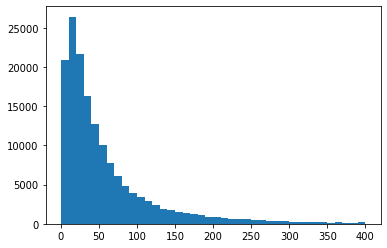

In [13]:
totalNumWords = [len(one_comment) for one_comment in sequencias]
plt.hist(totalNumWords,bins = np.arange(0,410,10))#[0,50,100,150,200,250,300,350,400])#,450,500,550,600,650,700,750,800,850,900])
plt.show()

Podemos perceber que a maioria das sequências contêm em torno de 50 palavras. De modo a não perdemos palavras que podem viar a ser imporantes, optou-se por deslocar o valor do nosso padding para 200 palavras. Esse valor pode e deve ser variado mais adiante para análisar sua influência no resultado final.

In [14]:
maxlen = 200

In [15]:
X = pad_sequences(sequencias, padding='post', maxlen= maxlen)
Y = y_treino.values

Para lidarmos com o split de um conjunto de dados multilabel, optou-se pelo uso da biblioteca Scikit-multilearn direcionada justamente para esse tipo de caso. 

## Interative_train_test_split

In [16]:
! pip install scikit-multilearn

You should consider upgrading via the '/Applications/anaconda3/bin/python -m pip install --upgrade pip' command.


Geralmente em problemas do tipo, uma abordagem comum é a de dividir os dados em "folds", ou seja porções aleatórias de nossa amostra. Algumas folds viram dados de treino e o restante de teste. Entretanto essa abordagem não gera evidência suficiente para cada classe me cada fold graças ao desbalanceamento de classes presente na maioria dos problemas. Isso por sua vez gera um modelo enviesado e com limitações em suas previsões.


De modo a solucionar essas problemáticas optamos por outra abordagem: o conceito por trás do método de `interative_train_test_split` é o de **"Estratificação"** que divide amostras do dataset em subsets que mantém uma proporção aproximadamente igual de elementos de cada classe em cada fold.

https://www.researchgate.net/publication/2352264_A_Study_of_Cross-Validation_and_Bootstrap_for_Accuracy_Estimation_and_Model_Selection

Lembrando que ja foi provado no artigo "A Study of Cross-Validation and Bootstrap for Accuracy Estimation and Model Selection" de Ron Kohavi que o método de estratificação se mostra mais estável se comparado com métodos de cross validation.

Uma análise técnica e aprofundada do método pode ser encontrada no artigo 'A Network Perspective on Stratification of Multi-Label Data', por Piotr Szymański and Tomasz Kajdanowicz  


https://arxiv.org/pdf/1704.08756.pdf


In [17]:
from skmultilearn.model_selection import iterative_train_test_split
#Lembrando que a seed é um método de garantir que sempre que rodarmos a função, ela terá o mesmo random state e consequentemente nos dará o mesmo resultado
np.random.seed(42)
x_train_sp, y_train_sp, x_test_sp, y_test_sp = iterative_train_test_split(X, Y, test_size=0.2)

## Verificando o split

### Função de contagem de ocorrência de labels

Agora, vamos verificar se de fato o split foi feito de uma forma balanceada garantindo uma proporção semelhante de cada tipo de comentario nos dados de treino e nos dados de teste.

Vamos primeiro criar uma função que conta as ocorrências de cada label:

In [18]:
def count_occurrences_labels(df):

  CLASSES = {
    'toxic':         0,
    'severe_toxic':  0,
    'obscene':       0,
    'threat':        0,
    'insult':        0,
    'identity_hate': 0,

  }

  for vet in df.values:
    for value, label in zip(vet, CLASSES):
      CLASSES[label] += int(value)

  return CLASSES

Em seguida criamos uma lista para armazernar o nome dos nossos labels:

### Função para calcular proporções de labels

Depois de fazer a contagem de quantas vez cada label aparece, precisamos determiar as proporções de cada um no conjunto de treino e no de teste para mais adiante verificarmos se elas são suficientemente próximas.

In [19]:
def calculates_labels_proportion(DICT_CLASSES, labels_names):

  proportions = {}

  for label in labels_names:
    prop = DICT_CLASSES[label]/sum(DICT_CLASSES.values())
    proportions.update({label: prop})
    
  df = pd.DataFrame([proportions])

  return df

### Ocorrência de labels em todo o data-set:

In [20]:
classif_data = count_occurrences_labels(dados_treino[labels])
classif_data

{'toxic': 15294,
 'severe_toxic': 1595,
 'obscene': 8449,
 'threat': 478,
 'insult': 7877,
 'identity_hate': 1405}

### Ocorrência de labels no subset de treino

In [21]:
classif_train = count_occurrences_labels(pd.DataFrame(y_train_sp))
classif_train

{'toxic': 12235,
 'severe_toxic': 1276,
 'obscene': 6759,
 'threat': 382,
 'insult': 6302,
 'identity_hate': 1124}

### Ocorrência de labels no subset de teste

In [22]:
classif_test = count_occurrences_labels(pd.DataFrame(y_test_sp))

classif_test

{'toxic': 3059,
 'severe_toxic': 319,
 'obscene': 1690,
 'threat': 96,
 'insult': 1575,
 'identity_hate': 281}

### Análise final com proporções

In [23]:
prop_data = calculates_labels_proportion(classif_data, labels)
prop_train = calculates_labels_proportion(classif_train, labels)
prop_test = calculates_labels_proportion(classif_test, labels)

result_prop = pd.concat([prop_data, prop_train, prop_test], ignore_index=True)
result_prop.rename(index={
    0: 'dataset', 
    1: 'train_set', 
    2: 'test_set'}, inplace=True)

result_prop


toxic  severe_toxic   obscene    threat    insult  identity_hate
dataset    0.435751      0.045444  0.240726  0.013619  0.224429       0.040031
train_set  0.435750      0.045445  0.240722  0.013605  0.224446       0.040031
test_set   0.435755      0.045442  0.240741  0.013675  0.224359       0.040028

Como é possivel ver na tabela acima, a proporção inicial do dataset se matém quase que a mesma após o split.

# Modelo Keras

## Input

Inicialmente estanciamos um tensor de entrada de dados. Configuramos ele para receber as sequências criadas anteriormente. 
Sabemos que nossas sequências possuem a dimensão de 200, e isso basta para configuramos esse tensor, o tamanho do `batch` será determinado mais a frente.

## Embedding Layer

Então já sabemos que cada palavra é associada a um número e cada frase representada por uma sequência de números.
Sabemos que cada palavra é um número, mas como ela é represenatda de fato? 


Supondo que temos os seguinte vocabulário:

{ Esse: 0, é: 1, um: 2, dicionário: 3 }

Como não são variáveis ordinais, ou seja, a ordem não importa. Não é interessente representarmos cada palavra simplismente pelo número atribuido à ela (Label Encoding)

Precisamos representar o que a palavra significa em relação a todo dicionário .

Uma abordagem comum e não ordinal é a chamada "Bag of Words" ou "One Hot Enconding" que consiste na vetorização das palavras. É criado um espaço vetorial com vetores distintos representado cada palavra. Tal vetor é compostos por zeros e 1 na posição correspondente à palavra específica. 

No caso a palavra "Esse" seria representada por [1,0,0,0], "é" seria [0,1,0,0] e a mesma lógica aplica-se às demais.

Essa técnica, entretanto, quando lidamos com uma grande quantidade de dados não se demonstra muito eficiente uma vez que adicionamos uma dimensão a mais no nosso espaço vetorial para cada palavra nova no vocabulário. Assim teriamos uma matriz esparsa enorme ocupando espaço e poder compuacional para ser processada.

Para ficar mais claro, imagina que temos um vocabulário de 200k palavras. Para representarmos uma dessas palavras precisariamos de um vetor com 200k dimensões e apenas uma delas contendo um valor diferente de zero. Além do mais, com essa abordagem como há uma dimensão nova para cada palavra, não é possível representar a similaridades entre as palavras.

Ai que entra o chamado 'Embending Layer'. De modo similar ao 'Bag of Words' o algoritmo por trás dessa camada cria um espaço vetorial para o nosso vocabulário. Entretanto a vetorização dessas palavras leva em consideração as palavras que aparecem próximas a elas em uma sentença. Dessa forma diminuimos drasticamento o tamanho do nosso modelo e das dimensões que precisamos lidar. 

Então palavras que geralmente estão no mesmo contexto vão ter coordenadas próximas uma da outra.
Por exemplo: "Gato" e "Cachorro" poderiam ser representados mais ou menos assim :
"Gato" - [0.881,0.764,0.219, ...,0.457]
"Cachorro" - [0.885,0.753,0.389, ...,0.105]
Repare que em muitas dimensões eles estão em coordenadas próximas indicando uma relação de similaridade entre as duas palavras.

Como parâmatros precisamos obrigatoriamente determinar o número de "unique words" ou o tamanho do nosso vocabulário e a dimensão que desejamos para nosso "Embedding Layer". 
O tamanho do espaço vetorial é um número arbitrário que pode e deve ser variado para analisar a sua interferência no resultado final.

## LSTM Layer

### Uma visão geral

Para o a próxima layer precisamos nos lembrar que uma rede neural (guardada as devidas proporções) próxima do funcionamento do cérebro humano. Uma característica fundamental de aprendizado é a **memória**. Nós não começamos a pensar do zero a cada segundo, nossos pensamentos têm persistência. É baseado nisso que a chamada Rede Neural Recorrente se baseia, ou seja, dados de inputs anteriores servem para o entendimento do input atual.

Um exemplo simples é a ferramenta de autocompletar a sua pesquisa no Google. Com base no que foi escrito anteriormente o Google consegue completar o que ele prevê que você está buscando:

<img src="imagens/google.png" width="500" height="500"/>




Uma rede neural recorrente (rnn) pode ser entendida como várias cópias de uma mesmas rede, cada uma passando uma mensagem a um sucessor:


<img src="imagens/rnn.png"  width="500" height="500"/>

Mas esse modelo tradicional de rnn têm uma limitação, quanto mais longe uma palavra está da outra pior ele vai inferir a correlação entre elas. Podemos grosseiramente dizer que ele possui uma memória bem curta, ele "lembra" mais só das palavras mais próximas da que se pretender prever.

Nesse momento que entra o chamado LSTM ou Long Short-Term Memory Networks um método semelhante ao anterior entratanto possui etapas intemediarias antes de passar informações para a rede seguinte. Ele possui os chamados "gates" que são como filtros que removem informações que não são úteis, da um pesor maior para úteis que são finalmente passadas para um output.

Basicamente então estamos garantindo que nosso modelo então baseará suas classificações de modo a condiderar o contexto das palavra e não só a sua aparição. Sabendo as palavras anteriores é possivel criar uma correlação ainda melhor entre elas, como por exemplo enteder que se uma palavra específica aparece anteior a outra palavra elá tem uma conotação, já se a ordem se inverte a conotação será outra.

De acordo com o próprio criador do Keras não é tão relevante entender a arquitetura do algorismo em detalhes e sim entender o que uma célula de LSMT foi criada para fazer: perminte que informações anteriores sejam reinjetadas mais tarde evitando o problema de "curta memória" (Vanishing Gradient Problem) 

O funcionamento é bem mais complexo que isso, para mais informações recomendamos as seguintes fontes:

http://deeplearningbook.com.br/arquitetura-de-redes-neurais-long-short-term-memory/

https://www.youtube.com/watch?v=WCUNPb-5EYI&t=1411s




No nosso caso, alimentamos a layer LSTM com o tensor resultante da layer de Embedding.
Esse tensor que estamos usando de entrada, como visto na última célula de código possui a dimensão (None, 200, 128).

    - O primeiro elemento é o tamanho da nossa amostra;
    - O segundo é o "Time steps" é o número de recursões que o LSTM rodará para cada input, é representado pelos 'A' acima. No nosso caso é o número máximo de palavras em uma frase;
    - O terceiro corresponde ao número de features de cada palavra, número que determinado na layer anterior de Embedding.

Essa layer rodará recursivamente por cada input (nossas frases) processando uma palavra de cada vez.
A cada time-step (ou palavra) podemos dizer que o output referente ao processamento nesse time-step conterá informação do processamento dos time-setps anteriores.


Como output teremos um tensor do formato (none,200,60). 

    - Novamente, o primeiro elemento diz respeito ao tamanho da nossa amostra;
    - O segundo são os time-steps;
    - E o terceiro são as features do nosso output.

Determinamos a dimensão do output desse layer para 60 features e que nosso output fosse "unrolled", isso é o equivalente a dizer que estamos retornando os outputs de cada time-step(h0,h1,h2...ht) e não somente o último(ht)



### Entende os passos por detrás do LSMT

Como já foi dito, LSTM é um tipo de Rede Neural Recorrente que consegue carregar uma memória de logo prazo. E isso é importante já que em textos nós precisamos de palavras mais anteirores para conseguirmos predizer o que virá em seguida,ou ainda para entender o entendimento de certas palavras por meio do contexto, sem dizer as outras aplicações.
Uma Rede Neural Recorrente Padrão - RNN- só tem um simples módulo de "tanh", nesse sentindo ele consegue criar uma memória a curto-prazo.


<img src="imagens/RNN1.png" alt="RNN1" width="500" height="500"/>

Já a LSTM possui 4 módulos interagindo de tal maneira que ele consegue passar informação para o outro "neurônio" criando uma memória de Longo prazo.

<img src="imagens/LSTM.png" alt="LSTM" width="500" height="500"/>


A partir disso, vamos entender os mecanismos por detrás do LSTM:

#### Ideia central do LSTM

A ideia central é está numa linha horizontal que percorre a parte de cima da célula a qual chamamos de estado da célula.

#### Imagem do estado de célula
                       
<img src="imagens/C.png" alt="state of cell" width="500" height="500"/>

Como se pode ver, ela só possui duas interações e são justamente poucas interações já que o intuito dela é somente passar informação adiante.

A partir dessas interações, o LSTM consegue adicionar ou remover informações do estado de célula. Essa alteração de informação é performada por estruturas chamadas de portas -gates-.

Antes de começarmos a falar dos passos performados pelas portas, vamos só criar uma legenda para facilitar o entendimento do processo:

<img src="imagens/L.png" alt="Legenda" width="500" height="500"/>

* Primeio ícone: Camada de Rede Neural
* Segundo ícone: Operação Ponto-a-Ponto
* Terceiro ícone: Vetor de Transferência

Como nessa variante de LSTM só vamos utilizar os três primeiros ícones da imagem, não há necessidade de descrever os outros.

Voltando as portas, podemos dizer que elas são formadas por uma camada de rede neural net sigmoid e uma operação de multiplicação ponto-a-ponto. Esse variante de LSTM possui três dessas portas para controlar o estado de célula.

<img src="imagens/gate.png" alt="gate" width="100" height="100"/>

Lembarando que uma Sigmoid retorna um valor entre zero e um, que nesse contexto significa o quanto de informação ele deixa fluir ou não. Ou sejas e for "zero" não passa nada e se for "um" passa tudo. 

Uma vez entendido os mecanismos, vamos falar sobre os processos.

#### Processo que ocorre no LSTM

 _O primeiro passo ocorre assim que recebemos a informação prévia do outro neurônio, e chega até a primeira operação do estado de célula:_
 
 A partir disso, ali será decidido qual informação a gente vai esquecer e qual a gente vai manter, e isso ocorre por meio da primeira porta sigmoid que temos na célula. Ela faz essa decisão através de uma função que recebe as informações $h_{t-1}$ e $x_t$, e a partir de uma lei ela retorna valores entre 1 e 0 no estado de célula $C_{t-1}$

 _Segue a frente um diagrama para visualizar esse primeiro processo e a lei de função:_
 
<img src="imagens/P1.png" alt="P1" width="500" height="500"/>

Uma vez adquirido a informação que queriamos da célula anterior, o próximo passo é escolher que informação nova - no caso dessa célula - adicioanaremos ao estado de célula.

Primeiramente, uma camada Sigmoid vai decidir que valor irá ser atualizado, após isso uma camada de tanh vai criar um vetor de novo possíveis valores - $C_t$ - para ser adicionado ao estado de célula. Essa combinação dessas duas camadas então é a responsável por essa atualização do estado.

 _Segue a frente um diagrama para visualizar esse segundo processo e as suas leis de função:_
 
<img src="imagens/P2.png" alt="P2" width="500" height="500"/>

Agora só falta atualizar o estado de célula antigo $C_{t-1}$ para o novo $\bar C\_t$, porque os passos antigos já determinaram isso só falta implementar. 

Para isso multiplicamos o antigo estado de célula por $f_t$ e então somamos com $i_t*\bar C\_t$

_Visualizando essa cálculo:_

<img src="imagens/cal.png" alt="cal" width="500" height="500"/>

Com isso, todas as alterações do estado de célula foram feitas e só falta decidir qual desses novo valores serão repassados.

Agora chegamosao ultimo passo, para decidir o que será o valor que será filtrado. Para fazer isso, primeiro será performado uma camada Sigmoid, para decidir quais valores serão retornados, e em seguida passamos o estado de célula por uma camada tanh, multiplicando o resultda da camada sigmoid com o da camada tanh, retornando assim somente as partes que foram escolhidas.

_Segue a frente um diagrama para visualizar esse terceuro e último processo e as suas leis de função:_
 
<img src="imagens/P3.png" alt="P3" width="500" height="500"/>

Portanto, é deste modo que funciona o LSTM. De fato, existem outras variantes, no entanto o intuito aqui era demosntrar a motivação e o funcionamento inicial de um LSTM.



## GlobalMaxPool1D layer

O output da camada anterior é um tensor "3d" de formato (none, 200, 60). Lembrando que `none`é nosso batch size, determinado mais adiante. 

Considerando ainda que teremos mais layers em nossa rede podemos dizer que nosso modelo terá um número demasiadamente alto de parâmatros para processar, o que demandaria um alto poder computacional e ainda poderia vir a gerar um 'overfitting' em nosso modelo.

Com a layer `GlobalMaxPool1D` esse output terá uma redução considerável de sua dimensão, uma vez que será transformado em tensor "2d". Mas ao diminuirmos a quantidade de coeficientes que temos, precisamos ter certeza de que os que resultarem desse processo sejam uma boa represetação dos dados originais. O `GlobalMaxPool1D` se encarrega disso basicamente percorrendo porções de nosso dado e retornando o maior valor encontrado em cada porção, garantindo assim a preservação da característica  mais acentuada de cada porção.

De modo a visualisar o que acontece com os dados em uma layer de "pooling" temos o exemplo a seguir:

<img src="imagens/maxpool.png"  width="500" height="500"/>

Outra caractéristica interessante que essa camada atribuirá ao nosso modelo é a chamada "Invariância da Tradução".
Para compreender esse conceito, observe o exemplo:
Digamos que possuimos dois grandes texto do tipo "ameaça". Em um as características mais acentuada que levam a essa classificação estão no começo da frase, no outro estão no final. Supondo ainda que uma dessas frases está na porção de treino e a outa na porção de teste. Sem o Max Polling nosso modelo terá dificuldade de indentificar um padrão se ele estiver em posições diferente da qual ele foi treinando, já com ele a característica pode estar presente em qualquer localização.

Para ser mais fácil de visualizar o que acontece, observe o exemplo a seguir.
<img src="imagens/maxpool2.png" width="300" height="300"/>
Repare que independente do posicionamento de "2" o resultado do pooling ainda será ele uma vez que é o maior número.

## Layer Dropout

*  ##  Regularização

Durante a construção de uma rede neural é importante que haja um processo de **Regularização** que é um processo cujo objetivo é a redução do erro de generalização, todavia não objetificando a diminuição do erro de treinamento - mesmo se ocorrer - . Tal processo visa dar a rede neural uma melhor performance a previsões fora da amostra  - isso está relacionado com a questão de chegar as informações populacionais ao invés de amostrais -, além disso ele objetifica resolver o problema de *Overfitting*.



Apesar da tentativa, os processos de Regularização não conseguiam resolver o problema do *Overfitting* de forma integral e isso se dava por causa do **Co-adaptation**. Um problema que foi resolvido pela introdução do **Dropout** no universo de *Deep Learning*.

&nbsp;



*  ## Dropout


Apesar de ser relativamente novo, o *Dropout* é um algoritmo para ajudar no treinamento de redes neurais que elimina aleatoriamente alguns neurônios durante o processe de aprendizagem do modelo, o que ajuda a chegar nos objetivos principais do processo de *Regularização*, principalmente o *Overfitting*.

Existe todo um processo matemático por detrás do **Dropout** que envolve uso de portas aliado a **distribuição de variáveis  Bernoulli** para fazer essa escolha de eliminação dos neurônios de forma randômica. 



Se quiser entender mais sobre esse processo por detrás do **Dropout**, esse link te trará uma explanação bem completa dele:
https://towardsdatascience.com/simplified-math-behind-dropout-in-deep-learning-6d50f3f47275

## Dense Layer

Uma Dense Layer é uma das camadas mais comuns quando tratamos de Redes Neurais. Cada neurônio dessa camada recebe input de todos os neurônios da camada anterior:


<img src="imagens/DenseLayer.png" width="500" height="500"/>


Essa camada realiza uma multiplicação matriz-vetor, em que os valores na matriz são, na verdade, parâmetros que são treinados e atualizados com a ajuda do sistema de "backpropagation". Aqui temos o output em formato de expressão matemática:

<img src="imagens/formula_dense.png" width="500" height="500"/>


Melhor explicando, cada neurônio da Dense Layer realiza o produto escalar entre o tensor de input e os valores da matriz do kernel, e soma esse valor a um BIAS (caso tenhamos setado o parâmetro para ter BIAS), que é um valor usada para otimizar o modelo. Por fim, esse valor passa pela função de ativação, que também escolhida na criação da camada, para que, então, cheguemos no output do neurônio. Essa função de ativação por padrão é linear, mas pode ser mudada para uma função não linear.

Fontes:

- [https://medium.com/datathings/dense-layers-explained-in-a-simple-way-62fe1db0ed75](https://medium.com/datathings/dense-layers-explained-in-a-simple-way-62fe1db0ed75)
- https://machinelearningknowledge.ai/keras-dense-layer-explained-for-beginners/#:~:text=The%20dense%20layer%20is%20a,performs%20a%20matrix%2Dvector%20multiplication
- [https://www.tutorialspoint.com/keras/keras_dense_layer.htm](https://www.tutorialspoint.com/keras/keras_dense_layer.htm)

### Funções de ativação

A biblioteca do TensorFlow oferece uma série de diferentes funções de ativação para serem usadas nas camadas. No nosso modelo, utilizamos duas funções diferentes, a Relu e a Sigmoid.

#### Relu 

<img src="imagens/relu.png" width="500" height="500"/>

Essa função é comumente vista como a função padrão a ser usada em uma camada quando há incerteza sobre qual função de ativação usar. Danqing Liu, no site medium.com, aponta três aspectos importantes da função ReLU:

- Baixa gasto computacional
- É de rápida conversão por conta de sua linearidade, que garante que a função não sature quando o x fica muito grande (fato observado em funções como tanh e sigmoid)
- Promove um processo de sparsity. De modo resumido, esse processo permite que a rede foque nos neurônios corretos (ligados a fato em análise), do que tenha uma rede super-ativada.

Um dos pontos negativos que o artigo de Danqing Liu pontua é que é muito difícil que um neurônio saia do estado de zero, e assim ele se torna inútil. Processo que pode, a longo prazo, tornar grande parte da rede inútil.

Fontes:

- [https://medium.com/@danqing/a-practical-guide-to-relu-b83ca804f1f7](https://medium.com/@danqing/a-practical-guide-to-relu-b83ca804f1f7)
- https://machinelearningmastery.com/rectified-linear-activation-function-for-deep-learning-neuralnetworks/#:~:text=In%20a%20neural%20network%2C%20the,or%20output%20for%20that%20input)

#### Sigmoid / Logistic Sigmoid

De maneira geral, essa função se caracteriza por restringir o output de 0 a 1, tornando o valor real em uma probabilidade. Esse novo valor é mais fácil de ser usado e interpretado.

<img src="imagens/sigmoid.png" width="500" height="500"/>

Existe uma série de funções sigmoides, mas no nosso caso, vamos utilizar a função Sigmoide Logística, que é mais comumente nomeada de função Sigmoide.

<img src="imagens/common_sigmoids.png" width="650" height="650"/>

Por fim, vale ressaltar a fórmula matemática da função sigmoide:

<img src="imagens/formula_sigmoid.png" width="400" height="400"/>

Um dos pontos negativos dessa função quando comparada com a ReLU, é que quando os valores de x se tornam muito grandes, aumentasse a demanda computacional e assim a rede neural fica mais lenta.

Fonte:

- https://towardsdatascience.com/multi-layer-neural-networks-with-sigmoid-function-deep-learning-for-rookies-2-bf464f09eb7f#:~:text=Sigmoid%20function%2C%20unlike%20step%20function,into%20our%20neural%20network%20model.&text=This%20non%2Dlinear%20activation%20function,decision%20boundary%2C%20such%20as%20XOR)
- [https://deepai.org/machine-learning-glossary-and-terms/sigmoid-function](https://deepai.org/machine-learning-glossary-and-terms/sigmoid-function)

## O Modelo

In [31]:
# Recomedamos uma versão mais antiga do tensorflow, a atual gerando problemas no treino do modelo. 
# pip install tensorflow==2.1

In [25]:
inp = Input(shape=(maxlen, ))

embed_size = 128
x = Embedding(max_features, embed_size)(inp)

x = LSTM(60, return_sequences=True,name='lstm_layer')(x)

x = GlobalMaxPool1D()(x)

x = Dropout(0.1)(x)

x = Dense(50, activation="relu")(x)

x = Dropout(0.1)(x)

x = Dense(6, activation="sigmoid")(x)

Até esse momento nós adicionamos as camadas, agora vamos compilar o modelo. Para a compilação do modelo, nós passaremos alguns parâmetros, os quais traremos uma breve explicação sobre.

## Otimizadores e Funções de Custo

### Otimizadores (Optimizers)

Otimizadores são algoritmos que visam otimizar e obter melhores resultados do modelo por meio da mudança dos parâmetros. Em cada nova interação o valor de uma variável é comparada com o valor ideal para aquela variável e assim ele consegue fazer as alterações para otimizar o modelo.

&nbsp;

*  ## Otimizador ADAM


Diferente do otimizador padrão **Gradiente Descendente Estocástico** o **ADAM** ele atualiza a *taxa de aprendizado* conforme cada iteração passa. Devido a essa característica, o **ADAM** é recomendado para modelos de *Processamento de Linguagem Natural* e *Visão Computacional* 

Além disso, o **ADAM** possui outros benefícios como:

 * Fácil implementação;
 * Computacionalmente Eficiente;
 * Aloca pouca memória;
 * Hiper-parâmetros possuem um interpretação intuitiva e tipicamente requerem pouco "tuning"
 
Existe toda uma matemática por detrás do modelo, caso queira entedê-la, só acesse este Link: https://towardsdatascience.com/adam-latest-trends-in-deep-learning-optimization-6be9a291375c




### A função de custo e porquê "Binary Cross Entropy"

Um dos hiperparâmetros mais importantes no aprendizado de maquina é a **função de custo**. Isso porque elá que irá mensurar o quão bom o modelo faz previsões, computando de alguma forma a distância entre os valores previstos pelo modelo e o valores reais, servindo posteriormente de referência para que o **otimizador** busque reduzir essa distância em uma próxima época.
Existem uma porção de algorítmos com esse intuito, cada um sendo otimizado para problemas de um determinado tipo.
Levando em consideração o fato de que estamos lidando com um caso de classificação no qual nossos comentários podem ser ou não ser de algum tipo(0 ou 1)a literatura é quase unânime em dizer que a funcão de **Entropia Cruzada Binária** (Binary Cross Entropy) é a mais indicada.
O conceito por trás do método remete à **Teoria da informação** de Claude E. Shannon, mas o embasamento teórico foge do escopo deste material.
No momento basta entendermos que o cálculo desse custo (loss) é dado pela seguinte equação:


 \[L(\hat{y}, y)=-\sum_{i =1}^{n}(y_{i}*log(\hat{y_{i}}))\]
 
Sendo  $y_{i}$ o valor real $\hat{y_{i}}$ o valor estimado.

A seguir um exemplo para enteder melhor o cáclulo.
Supondo que possuímos as seguintes 3 categorias para classificação: cachorro, gato, baiacu:



<img src="imagens/cross.jpg"  width="500" height="500"/>




\[L(\hat{y}, y)=-(({\color{Pink} 1}*{\color{Orange}\log (0,6) })+({\color{Pink} 0}*{\color{Orange}\log (0,15) })+({\color{Pink} 0}*{\color{Orange}\log (0,25) })\]

\[L(\hat{y}, y)=0,73\].

A relação entre o custo e a probabilidade da predição pode ser vista com o gráfico:



<img src="imagens/grafico_cross.png"  width="500" height="500"/>

Como é possível ver quanto maior é o custo (log loss) mais distante a predição estará da realidade.



## Compilando, treinando e validando o modelo

In [26]:
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

In [27]:
batch_size = 32
epochs = 2
model.fit(x_train_sp,y_train_sp, batch_size=batch_size, epochs=epochs, validation_data=(x_test_sp,y_test_sp))

Train on 127656 samples, validate on 31915 samples
Epoch 1/2
127656/127656 [==============================] - 620s 5ms/sample - loss: 0.0665 - accuracy: 0.9775 - val_loss: 0.0498 - val_accuracy: 0.9818
Epoch 2/2
127656/127656 [==============================] - 3121s 24ms/sample - loss: 0.0459 - accuracy: 0.9827 - val_loss: 0.0466 - val_accuracy: 0.9827


In [28]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 200, 128)          2560000   
_________________________________________________________________
lstm_layer (LSTM)            (None, 200, 60)           45360     
_________________________________________________________________
global_max_pooling1d (Global (None, 60)                0         
_________________________________________________________________
dropout (Dropout)            (None, 60)                0         
_________________________________________________________________
dense (Dense)                (None, 50)                3050      
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0     